# When and where do fires start ?

The aim of this code is to take as an input the daily fire risk maps and to create a list of dates and lon / lat where ignitions occurs. 

#### 1. Scaling part (from other code in 2.run-select-points):
- Calculate number of yearly historical fires and yearly sum of probabilities above a threshold (from ML model). 
- Linear regression of the ML yearly sum to the yearly historical fires

--> output: slope + intercept

#### 2. Apply scaling to fire risk probabilities to obtain daily number of fires (When fires happen?):
- Obtain the yearly expected number of fires by applying scaling to ML fire risk probabilities
- For each year define a factor as expected number of fires / sum of probability above threshold and scale the daily probabilities

--> output: for each day, the number of fires starting across Europe 

#### 3. Select location of fires (Where fires happen?)
- Loop through each day and select location of fire based on either a threshold value of the dice method (see code for more info)

--> output: List of dates with corresponding lon / lat

#### 4. Visualise and compare results to observation
- Calculate number of fires generated for each 10x10km grid cell
- Compare the range of ids / locations

The list is then used to run ForeFire. 

In [499]:
import geopandas as gpd
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [500]:
def round_half_up(x):
    return np.floor(x + 0.5)

In [501]:
folder = "ML-data-Europe-gridded"

In [502]:
path = "O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/" + folder + "/"

#### Load datasets: ML probabilities

In [503]:
start_year = '1991'
end_year = '2010'
ens = 'epp'
save = False

In [504]:
# Fire probability
df_probs = pd.read_csv(path + 'results/climex/'+ ens + '/daily_probas_' + start_year + '-' + end_year + '_fire-season.csv') #path + 'results/all-predictors/daily_probas_2008-2023_fire-season.csv')

In [505]:
df_probs = df_probs.set_index(np.int64(df_probs.id))

In [507]:
df_probs = df_probs.iloc[:, 1:] # remove id column at the beginning of table

In [509]:
df_probs = df_probs.iloc[:, :-1] # remove mean column at the end of table

In [510]:
# Update column names to date times 
dates = pd.date_range(start_year + '-01-07', end_year + '-12-24')

# Only fire season so months outside fire season are filtered out 
for m in [1, 2, 3, 4, 5, 11, 12]:
    dates = dates[ ~(dates.month == m)]

df_probs = df_probs.set_axis(dates, axis=1)

In [511]:
df_probs

,1991-06-01,1991-06-02,1991-06-03,1991-06-04,1991-06-05,1991-06-06,1991-06-07,1991-06-08,1991-06-09,1991-06-10,...,2010-10-22,2010-10-23,2010-10-24,2010-10-25,2010-10-26,2010-10-27,2010-10-28,2010-10-29,2010-10-30,2010-10-31
68467,0.113333,0.080000,0.093333,0.026667,0.020000,0.026667,0.026667,0.026667,0.026667,0.026667,...,0.193333,0.193333,0.200000,0.206667,0.240000,0.226667,0.240000,0.260000,0.353333,0.213333
68468,0.113333,0.153333,0.100000,0.060000,0.086667,0.060000,0.060000,0.060000,0.066667,0.066667,...,0.220000,0.226667,0.253333,0.253333,0.260000,0.253333,0.260000,0.260000,0.360000,0.253333
68474,0.093333,0.093333,0.106667,0.060000,0.060000,0.060000,0.040000,0.046667,0.046667,0.046667,...,0.160000,0.160000,0.160000,0.160000,0.160000,0.153333,0.133333,0.140000,0.140000,0.146667
68475,0.166667,0.180000,0.153333,0.080000,0.080000,0.080000,0.080000,0.080000,0.080000,0.073333,...,0.306667,0.306667,0.306667,0.326667,0.326667,0.333333,0.320000,0.313333,0.326667,0.313333
68476,0.140000,0.153333,0.166667,0.093333,0.086667,0.093333,0.086667,0.093333,0.093333,0.086667,...,0.253333,0.253333,0.273333,0.306667,0.293333,0.300000,0.320000,0.333333,0.400000,0.380000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110367,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,...,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667,0.566667
112786,0.186667,0.266667,0.240000,0.233333,0.246667,0.073333,0.153333,0.093333,0.140000,0.160000,...,0.280000,0.280000,0.186667,0.326667,0.346667,0.086667,0.160000,0.173333,0.286667,0.080000
113006,0.520000,0.573333,0.553333,0.406667,0.406667,0.140000,0.406667,0.186667,0.366667,0.486667,...,0.606667,0.606667,0.566667,0.546667,0.446667,0.193333,0.320000,0.380000,0.480000,0.153333
113226,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,...,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000,0.260000


### Slope and intercept obtained from era5-land /historical fire code

In [512]:
slope =  np.load(path +  'results/all-predictors/slope.npy')
print(slope) #0.0106
intercept  = np.load(path +  'results/all-predictors/intercept.npy')
print(intercept) #-1654 

0.01058285483828872
-1654.3302873899402


In [513]:
years = np.arange(int(start_year), int(end_year)+ 1, 1)
prob = 0.7# select threshold value

### 2. Calculate daily number of fires

In [514]:
df_count = pd.DataFrame(index = dates)

In [515]:
df_count['count'] = ''

In [516]:
combined_fires_ml = np.zeros(153)
combined_fires_yearly_ml = np.zeros((len(years), 153))
yearly_sum_ml = []

for y, year in enumerate(years): 

    year = str(year)
    dates_year = dates[dates.year == int(year)]

    ### 2. ML fires 
    
    # Select only the probabilities from a given year 
    df = df_probs.filter(like= year)
    
    prob_filter = np.zeros(len(dates_year))
    
    k = 0
    for column_name, item in df.items():
        vals = np.zeros(len(item))
        vals[item > np.ones(len(vals)) * prob] = 1
        prob_filter[k] = np.sum(vals)       
        k = k+1
        
    combined_fires_ml = combined_fires_ml + prob_filter
    yearly_sum_ml.append(np.nansum(prob_filter))
    print(np.nansum(prob_filter))
    combined_fires_yearly_ml[y, :] = prob_filter
   

203167.0
232559.0
157407.0
224594.0
192682.0
183172.0
178473.0
203062.0
218232.0
219640.0
257664.0
217374.0
209690.0
172424.0
193883.0
243772.0
225254.0
219243.0
223737.0
224607.0


(0.0, 3000.0)

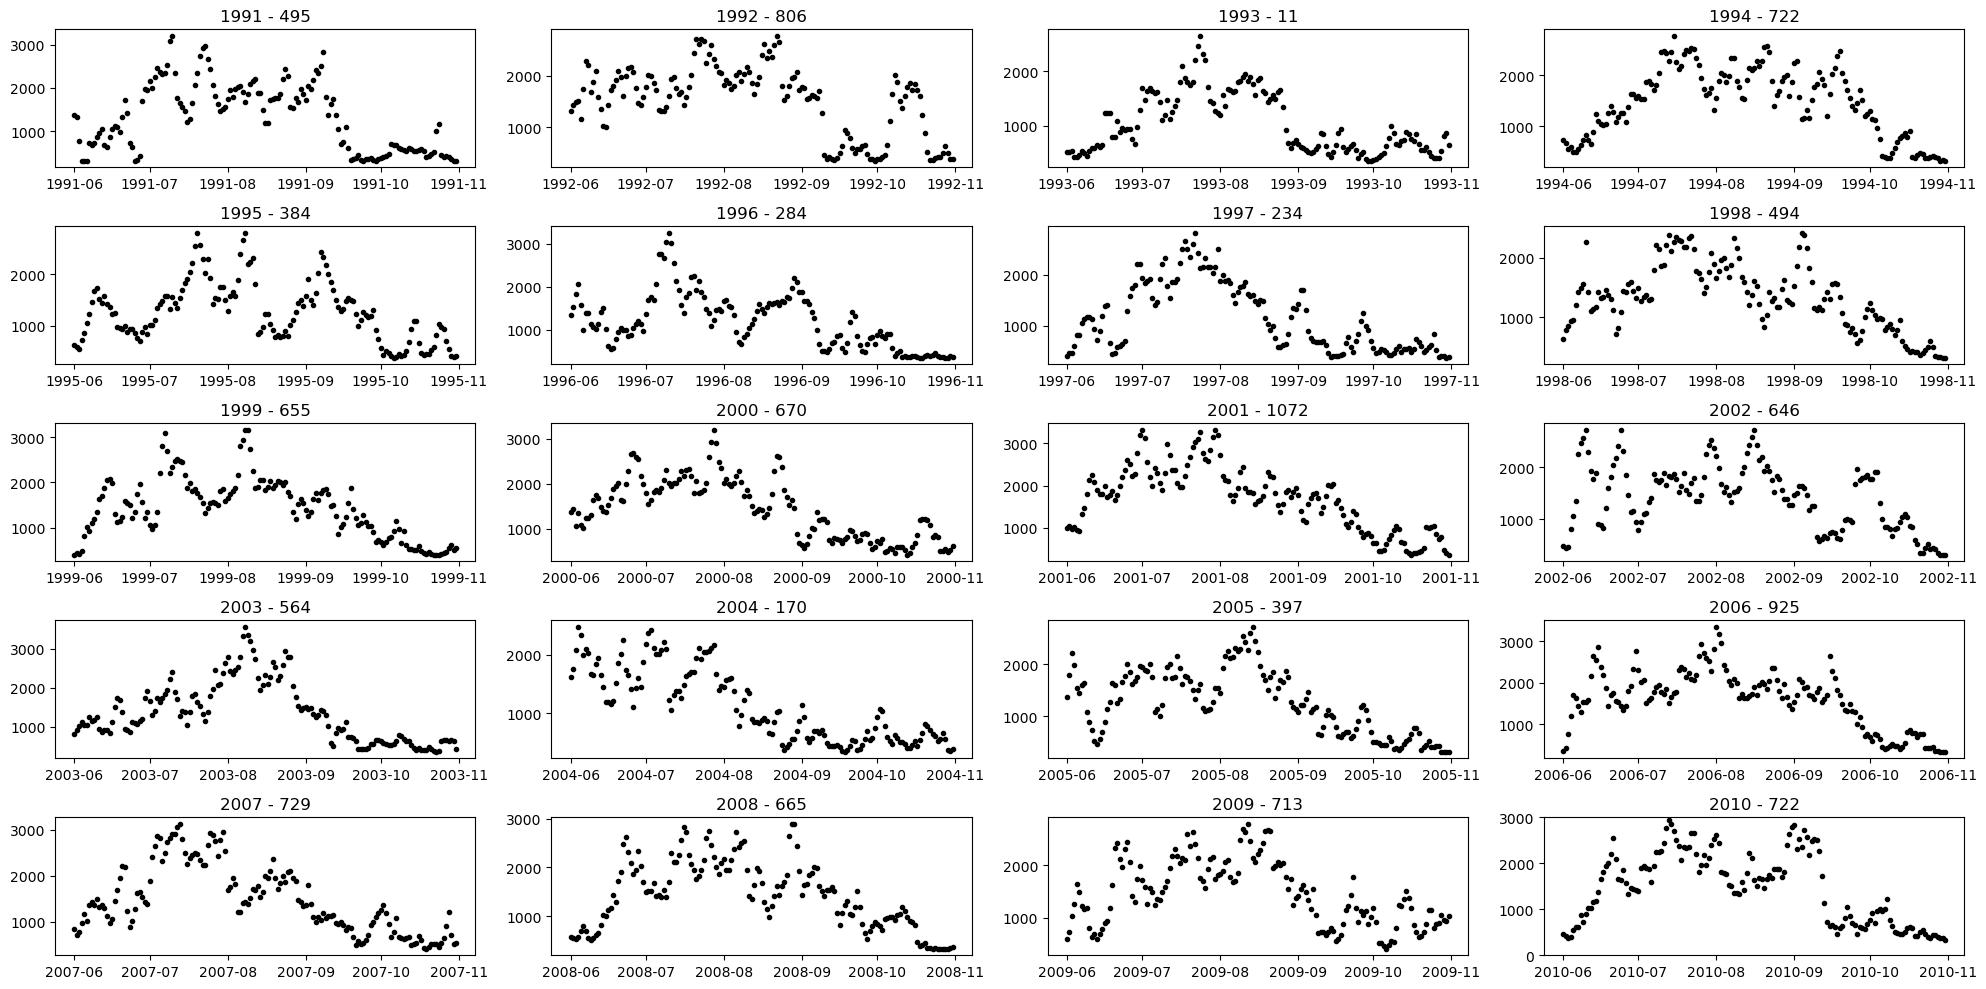

In [517]:
total_count_fires = []

fig, axs = plt.subplots(5, 4, figsize = (20, 10)) 
for i, year in enumerate(years):
    
    # Select only dates for a given year
    dates_year = dates[dates.year == int(year)]

    # Obtain number of expected fires from linear regression
    sum_year = yearly_sum_ml[i]*slope + intercept
    
    # Plot
    ax = fig.axes[i]
    ax.plot(dates_year, combined_fires_yearly_ml[i, :], 'k.', label = 'ML'+ ' : ' + str(int(sum_year)))
    ax.set_title(str(years[i]) + ' - ' + str(int(sum_year)))

plt.tight_layout()
ax.set_ylim(0, 3000)

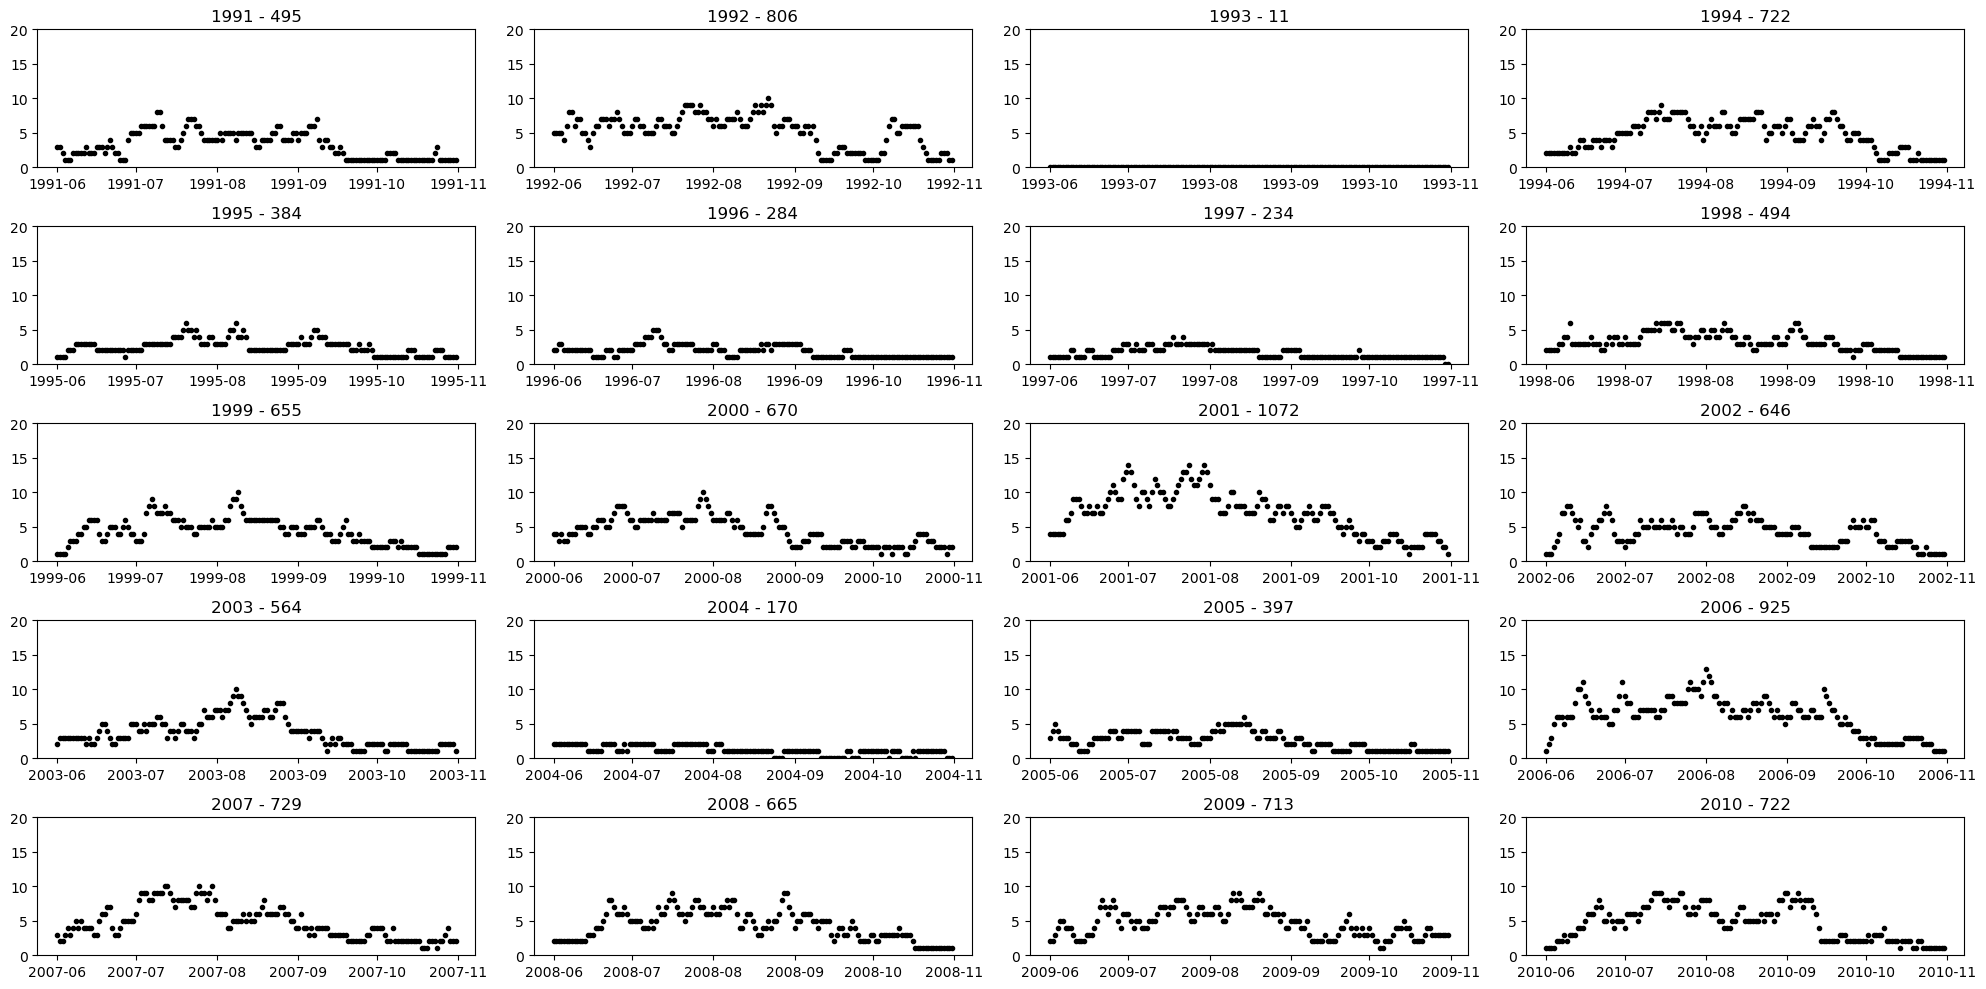

In [518]:
total_count_fires = []

fig, axs = plt.subplots(5, 4, figsize = (20, 10)) 
for i, year in enumerate(years):
    
    # Select only dates for a given year
    dates_year = dates[dates.year == int(year)]

    # Obtain number of expected fires from linear regression
    sum_year = yearly_sum_ml[i]*slope + intercept

    # Calculate factor 
    factor = np.nansum(combined_fires_yearly_ml[i, :])/ sum_year

    # Obtain number of fires and add to list 
    scaled_number_fires = round_half_up(combined_fires_yearly_ml[i, :]/factor)
    scaled_number_fires[scaled_number_fires < 0] = 0
    total_count_fires= np.concatenate([total_count_fires, scaled_number_fires])

    # Plot
    ax = fig.axes[i]
    ax.plot(dates_year, scaled_number_fires, 'k.', label = 'ML'+ ' : ' + str(int(sum_year)))
    ax.set_title(str(years[i]) + ' - ' + str(int(sum_year)))
    ax.set_ylim(0, 20)
plt.tight_layout()

In [519]:
df_count['count']= total_count_fires

Text(0, 0.5, '# of fires')

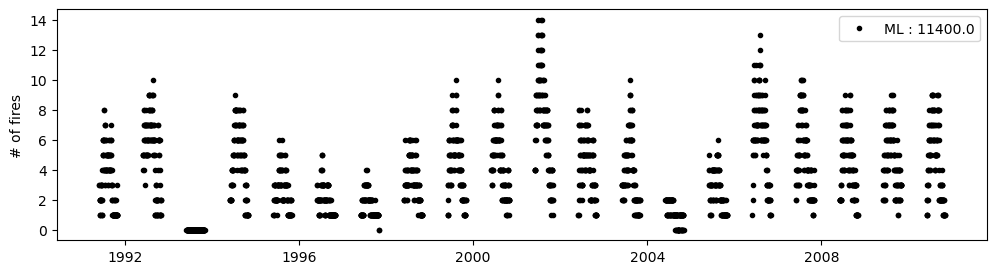

In [521]:
fig, ax = plt.subplots(figsize = (12, 3))
ax.plot(dates, df_count['count'].values, 'k.', label = 'ML : ' + str(np.nansum(df_count['count'].values)))
#ax.plot(dates, combined_fires_yearly.flatten(), '.' , zorder = 0, label = 'Obs : ' + str(np.nansum(combined_fires_yearly.flatten())))
ax.legend()
ax.set_ylabel('# of fires')


Text(0, 0.5, '# of fires')

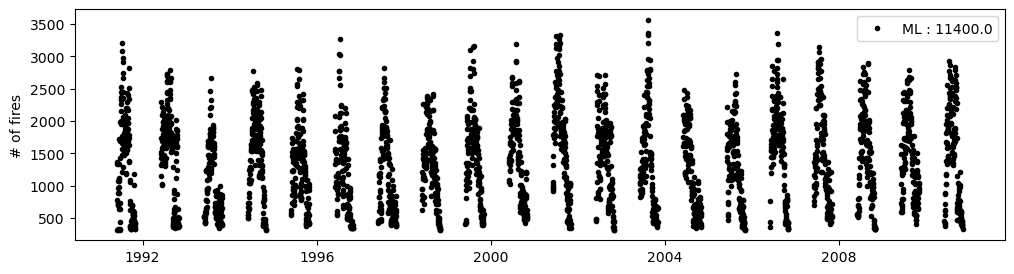

In [522]:
fig, ax = plt.subplots(figsize = (12, 3))
ax.plot(dates, combined_fires_yearly_ml.flatten(), 'k.', label = 'ML : ' + str(np.nansum(df_count['count'].values)))
#ax.plot(dates, combined_fires_yearly.flatten(), '.' , zorder = 0, label = 'Obs : ' + str(np.nansum(combined_fires_yearly.flatten())))
ax.legend()
ax.set_ylabel('# of fires')


In [523]:
if save == True:
    df_count.to_csv(path + 'results/climex/' + ens + '/df_count.csv')

### 3. Select location for each date 

#### Select method to use 

NOTE: The same threshold is used as defined in 1.

In [524]:
select_type = 'thresh' # or dice 

In [525]:
df_probs['id'] = df_probs.index

#### For each day, sample a number of ids corresponding to the number of fires

In [526]:
df_ignition = pd.DataFrame(columns = ['date', 'id'])

i = 0
for year in years: 
    year = str(year)
    df = df_probs.filter(like= year)
    
    for column_name, item in df.items():
        
        # Random probability
        vals = np.zeros(len(item))
        random_probas = np.random.rand(len(item))

        # Use sample function to select ids based on condition
        n = int(df_count['count'][i])
        if n < 0:
            n = 0
        if select_type == 'thresh':
            indices = df_probs['id'][item > prob].sample(n)
        elif select_type == 'dice':
            indices = df_probs['id'][item > random_probas].sample(n)

        # Create a dataframe with a row per fire 
        for ind in indices:
            df_temp = pd.DataFrame({"date":[str(column_name)[:10]], "id": [ind]})
            df_ignition = pd.concat([df_ignition, df_temp], ignore_index=True)
            
        i = i +1   
       

C:\Users\ophme\AppData\Local\Temp\ipykernel_32120\3981791348.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = int(df_count['count'][i])


In [527]:
df_ignition

,date,id
0,1991-06-01,85045
1,1991-06-01,100038
2,1991-06-01,98922
3,1991-06-02,95816
4,1991-06-02,99141
...,...,...
11395,2010-10-27,43188
11396,2010-10-28,96028
11397,2010-10-29,108164
11398,2010-10-30,83722


#### Assign geometry to corresponding id

In [528]:
grid = gpd.read_file("O:/Climate-and-Energy-Policy/CERM/Projects/Wildfire/Data/" + folder + "/grid/europe_10km_grid.shp")

In [529]:
grid = grid[['id', 'geometry']].to_crs(4326)

In [530]:
grid['id'] = grid['id'].astype('int')

In [531]:
grid = grid.set_index('id')

In [532]:
geometries = []
for i, row in df_ignition.iterrows():
    geometries.append(grid.loc[row.id, 'geometry'])

In [533]:
df_ignition['geometry'] = geometries

#### Convert to geopandas and sample point randomly within grid 

In [534]:
df_ignition_gpd = gpd.GeoDataFrame(df_ignition, geometry=df_ignition["geometry"])

In [535]:
df_ignition_gpd['sample_point'] = df_ignition_gpd.geometry.sample_points(1)

In [536]:
df_ignition['lon'] = df_ignition_gpd.sample_point.x
df_ignition['lat'] = df_ignition_gpd.sample_point.y

In [537]:
df_ignition

,date,id,geometry,lon,lat
0,1991-06-01,85045,POLYGON ((15.741549191022367 39.93612107620301...,15.736418,39.942897
1,1991-06-01,100038,POLYGON ((22.93590332952846 36.175012200070334...,22.935911,36.200136
2,1991-06-01,98922,"POLYGON ((22.6027413322363 37.778736758889664,...",22.695172,37.752605
3,1991-06-02,95816,POLYGON ((21.435167683039623 40.30180083385478...,21.526351,40.214282
4,1991-06-02,99141,POLYGON ((22.731137234338377 37.85313945382895...,22.827011,37.834292
...,...,...,...,...,...
11395,2010-10-27,43188,MULTIPOLYGON (((-7.734263747170534 43.74754900...,-7.679652,43.730307
11396,2010-10-28,96028,"POLYGON ((21.6687584099283 40.914236711541434,...",21.715585,40.931829
11397,2010-10-29,108164,POLYGON ((27.27641210659175 36.833651550595164...,27.282828,36.836595
11398,2010-10-30,83722,POLYGON ((15.006380388791456 40.20704381067912...,14.964851,40.237549


#### Save list of points

In [538]:
if save == True:
    df_ignition.drop(columns = ['id', 'geometry']).to_csv(path + 'results/ignition-selection/fire-season-ignition-points-' + start_year + '-' + end_year + '-' + select_type + '07_climex_' + ens +  '.csv')

### 4. Visualise results 

#### Groupd by id and counter the number of fires per id

In [539]:
new_data = df_ignition.groupby('id').size().reset_index(name='count')
len(new_data)

3751

In [540]:
for i, row in new_data.iterrows():
    new_data.loc[i, 'geometry'] = grid.loc[row.id, :].geometry



In [541]:
new_data = gpd.GeoDataFrame(new_data, geometry=new_data["geometry"])


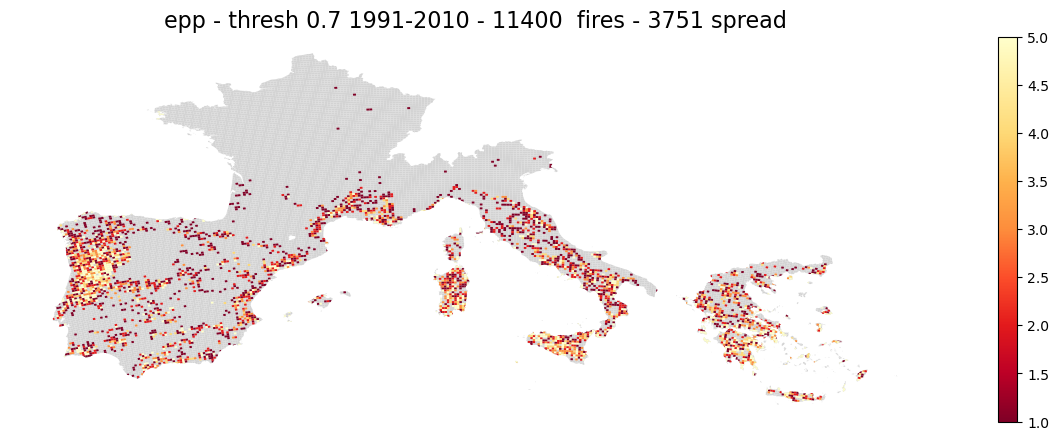

In [542]:
fig, ax = plt.subplots(figsize = (15, 10))
grid.plot(color = 'lightgrey', ax = ax, zorder = 0)
new_data.plot('count', ax = ax, cmap = 'YlOrRd_r', legend = True, vmin = 1, vmax = 5, legend_kwds={
        "shrink":.5   },)
#fires.plot(ax = ax,  color = 'k', zorder = 10)
if select_type == 'dice':
    ax.set_title(select_type, fontsize = 12)
else:
   ax.set_title(ens + ' - ' + select_type + ' ' + str(prob) +' ' + start_year + '-' + end_year + ' - ' + str(len(df_ignition)) + '  fires - ' + str(len(new_data)) + ' spread' , fontsize = 16)
#
ax.set_axis_off()